# Installing Prerequisites:

In [1]:
!pip install diffusers transformers accelerate scipy safetensors supervision jupyter_bbox_widget
!git clone https://github.com/IDEA-Research/GroundingDINO.git
!git clone https://github.com/facebookresearch/segment-anything-2.git

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 44.8 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 463 (delta 176), reused 137 (delta 137), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 15.24 MiB/s, done.
Resolving deltas: 100% (241/241), done.
Cloning into 'segment-anything-2'...
remote: Enumerating objects: 510, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 510 (delta 142)

# Preparing Grounding DINO model:

In [2]:
%cd GroundingDINO
!pip install -e .

/content/GroundingDINO
Obtaining file:///content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 19.4 MB/s eta 0:00:00
  Running setup.py develop for groundingdino


In [3]:
import os
import sys
import torch
import numpy as np
from google.colab.patches import cv2_imshow

from PIL import Image
from torchvision.ops import box_convert

sys.path.append('/GroundingDINO')

import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from groundingdino.util.inference import annotate, load_image, predict

import cv2
import matplotlib.pyplot as plt

from huggingface_hub import hf_hub_download


In [4]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):

    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)
    args = SLConfig.fromfile(cache_config_file)
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model


In [5]:

ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

%cd /content/segment-anything-2
!pip install -e . -q


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.3 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done


In [6]:

!echo "Downloading sam2_hiera_large.pt checkpoint..."
!wget "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt" || { echo "Failed to download checkpoint from $sam2_hiera_l_url"; exit 1; }

!echo "SAM-2 is downloaded successfully."

--2024-09-27 23:01:06--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15, 13.226.210.111, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 897952466 (856M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_large.pt’

sam2_hiera_large.pt 100%[===================>] 856.35M   126MB/s    in 8.8s    

2024-09-27 23:01:15 (96.9 MB/s) - ‘sam2_hiera_large.pt’ saved [897952466/897952466]

SAM-2 is downloaded successfully.


In [7]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [8]:
def build_models():

    HOME = os.getcwd()
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    CHECKPOINT = f"{HOME}/sam2_hiera_large.pt"
    CONFIG = "sam2_hiera_l.yaml"

    sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)
    sam_predictor = SAM2ImagePredictor(sam2_model)
    return sam2_model, sam_predictor, DEVICE

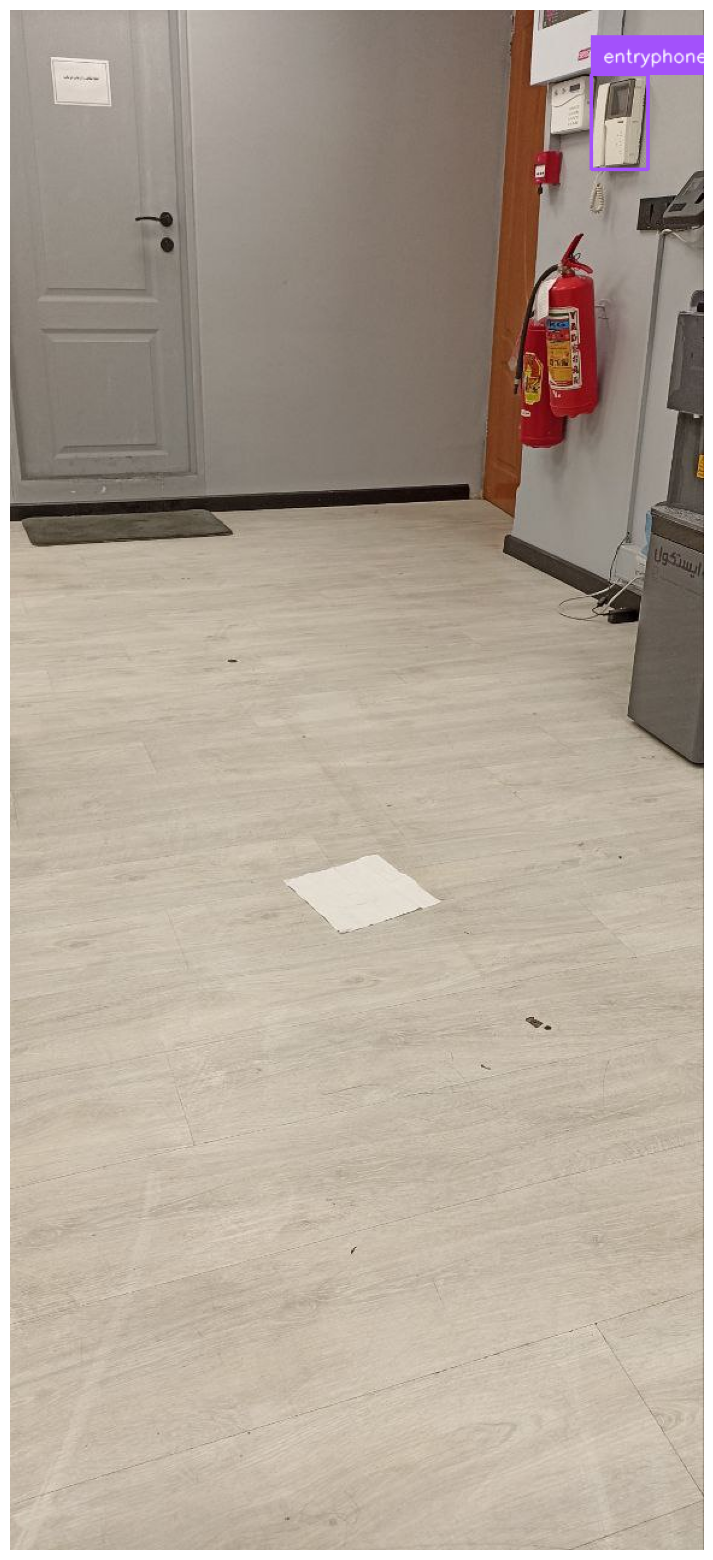

In [9]:
def visualize_grounding_dino(prompt):

    sam2_model, sam_predictor, DEVICE = build_models()

    IMAGE_PATH = "/content/1.jpg"

    BOX_TRESHOLD = 0.3
    TEXT_TRESHOLD = 0.25

    image_source, image = load_image(IMAGE_PATH)

    boxes, logits, phrases = predict(
        device=DEVICE,
        model=groundingdino_model,
        image=image,
        caption=prompt,
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    if boxes.shape[0] > 1:
        index = logits.argmax()
        boxes = boxes[index].unsqueeze(dim=0)
        logits = logits[index].unsqueeze(dim=0)
        phrases = [phrases[index]]

    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    annotated_frame = annotated_frame[...,::-1] # BGR to RGB
    plt.figure(figsize=(20, 20))
    plt.imshow(annotated_frame)
    plt.axis('off')
    plt.show()


# visualize_grounding_dino("White square paper")
# visualize_grounding_dino("coffee machine")
# visualize_grounding_dino("Fire extenguisher")
# visualize_grounding_dino("door knob")
visualize_grounding_dino("entryphone")
# visualize_grounding_dino("floor")


# Floor Masking:

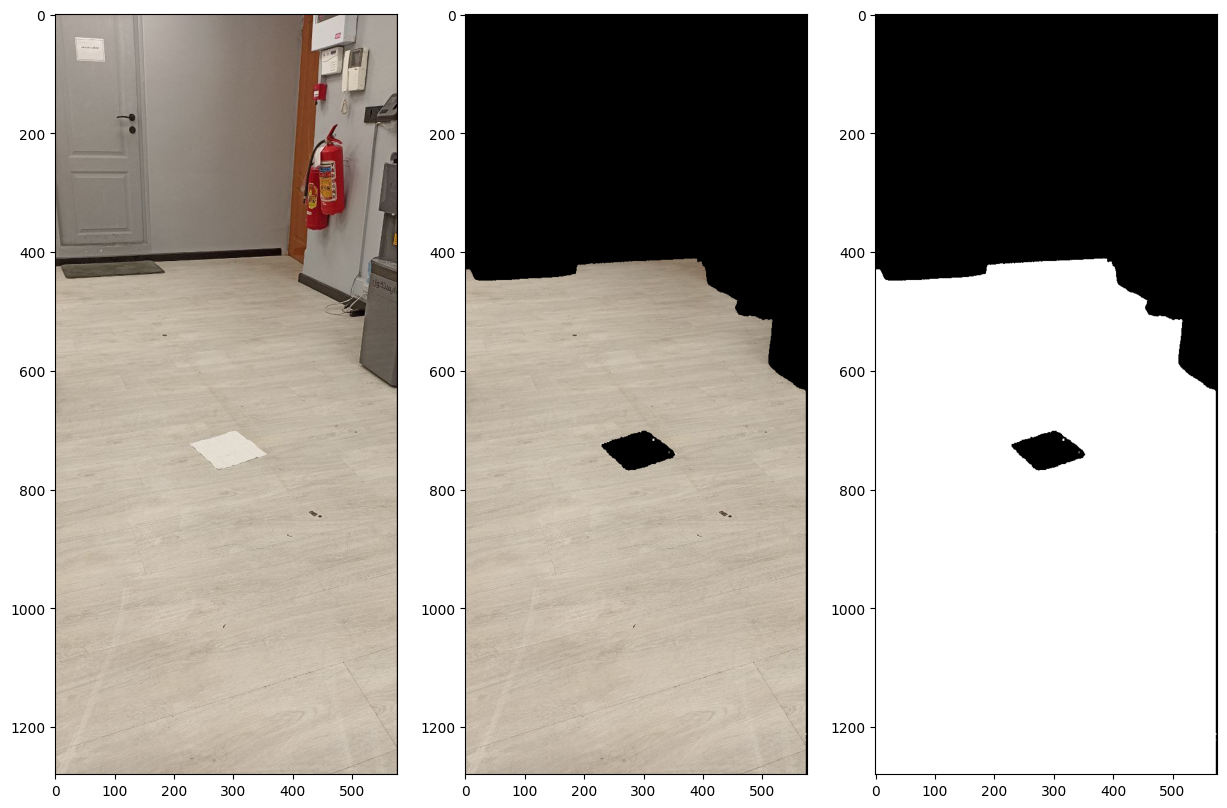

In [10]:
def segment_floor(image, image_source, sam_predictor, DEVICE):

    TEXT_PROMPT = "floor"
    BOX_TRESHOLD = 0.3
    TEXT_TRESHOLD = 0.25

    boxes, logits, phrases = predict(
        model=groundingdino_model,
        device=DEVICE,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    if boxes.shape[0] > 1:
        index = logits.argmax()
        boxes = boxes[index].unsqueeze(dim=0)
        logits = logits[index].unsqueeze(dim=0)
        phrases = [phrases[index]]

    sam_predictor.set_image(image_source)

    H, W, _ = image_source.shape
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

    masks, _, _ = sam_predictor.predict(
                point_coords = None,
                point_labels = None,
                box = boxes_xyxy,
                multimask_output = False,
            )

    floor_mask = np.stack((masks.squeeze(),)*3,axis=-1)
    floor_pixels = np.where(floor_mask == True, image_source, 0)
    return floor_pixels, floor_mask



IMAGE_PATH = "/content/1.jpg"
image_copy, new_img = load_image(IMAGE_PATH)
plt_image = plt.imread(IMAGE_PATH)
sam2_model, sam_predictor, DEVICE = build_models()
floor_pixels, floor_mask = segment_floor(new_img, image_copy, sam_predictor, DEVICE)

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(plt_image)
plt.subplot(1,3,2)
plt.imshow(floor_pixels)
plt.subplot(1,3,3)
plt.imshow(floor_mask)
plt.show()

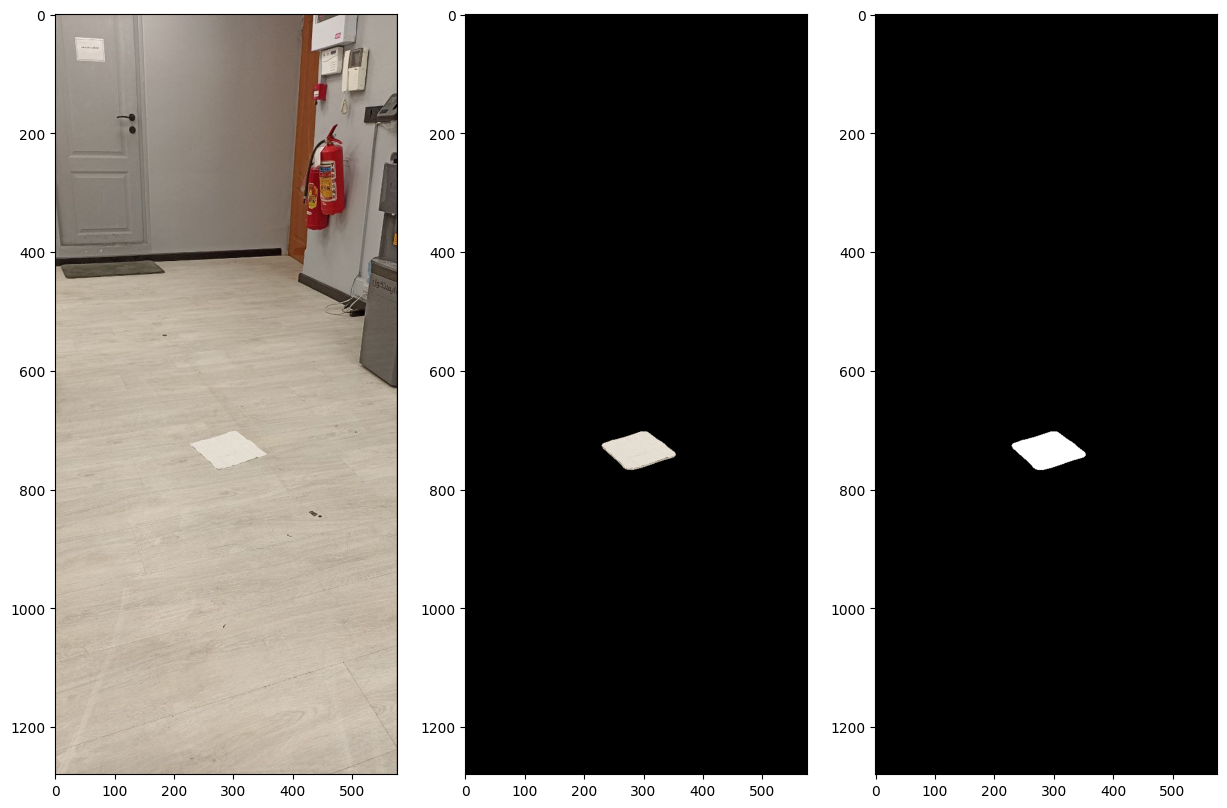

In [11]:
def smooth_mask(mask):
    smooth_mask = cv2.bilateralFilter(mask.astype(np.uint8), d=9, sigmaColor=75, sigmaSpace=75)
    return smooth_mask

def segment_tissue(image, image_source, sam_predictor, DEVICE):

    TEXT_PROMPT = "white square paper"
    BOX_TRESHOLD = 0.3
    TEXT_TRESHOLD = 0.25

    boxes, logits, phrases = predict(
        device=DEVICE,
        model=groundingdino_model,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    if boxes.shape[0] > 1:
        index = logits.argmax()
        boxes = boxes[index].unsqueeze(dim=0)
        logits = logits[index].unsqueeze(dim=0)
        phrases = [phrases[index]]

    sam_predictor.set_image(image_source)

    H, W, _ = image_source.shape
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

    masks, _, _ = sam_predictor.predict(
                point_coords = None,
                point_labels = None,
                box = boxes_xyxy,
                multimask_output = False,
            )


    smooth_tissue_mask = smooth_mask(masks.squeeze())

    tissue_mask = np.stack((smooth_tissue_mask,)*3,axis=-1)
    tissue_pixels = np.where(tissue_mask == True, image_source, 0)
    return tissue_pixels, tissue_mask



IMAGE_PATH = "/content/1.jpg"
image_copy, new_img = load_image(IMAGE_PATH)
plt_image = plt.imread(IMAGE_PATH)
sam2_model, sam_predictor, DEVICE = build_models()
tissue_pixels, tissue_mask = segment_tissue(new_img, image_copy, sam_predictor, DEVICE)

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(plt_image)
plt.subplot(1,3,2)
plt.imshow(tissue_pixels)
plt.subplot(1,3,3)
plt.imshow(tissue_mask.astype(np.float32))
plt.show()

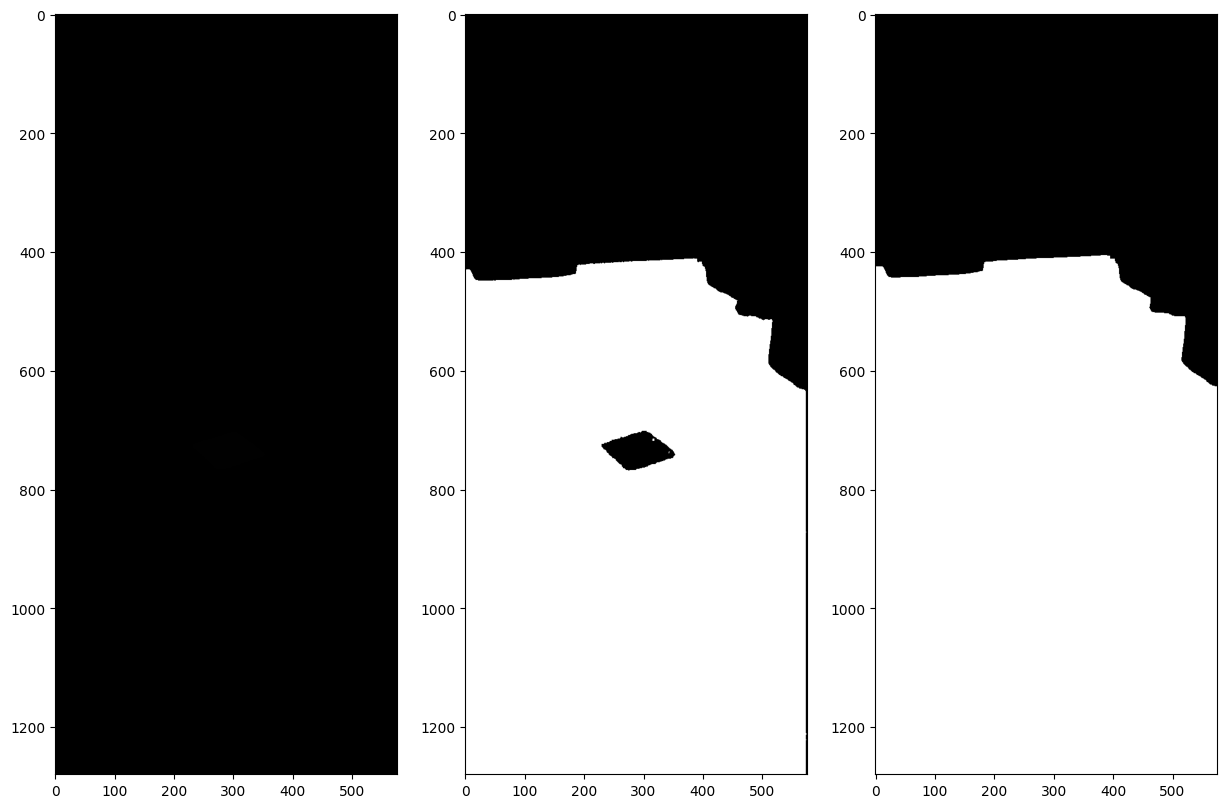

In [12]:
def dilate_mask(mask, kernel_size=3, iterations=5):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=iterations)
    return dilated_mask

def mix_tissue_and_floor_mask(tissue_mask, floor_mask):
    tissue_mask_dilated = dilate_mask(tissue_mask)
    floor_mask_dilated = dilate_mask(floor_mask)
    return np.bitwise_or(tissue_mask_dilated.astype(int), floor_mask_dilated.astype(int))



IMAGE_PATH = "/content/1.jpg"
image_copy, new_img = load_image(IMAGE_PATH)
plt_image = plt.imread(IMAGE_PATH)
sam2_model, sam_predictor, DEVICE = build_models()
tissue_pixels, tissue_mask = segment_tissue(new_img, image_copy, sam_predictor, DEVICE)
floor_pixels, floor_mask = segment_floor(new_img, image_copy, sam_predictor, DEVICE)

mixed_mask = mix_tissue_and_floor_mask(tissue_mask, floor_mask)
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(tissue_mask)
plt.subplot(1,3,2)
plt.imshow(floor_mask)
plt.subplot(1,3,3)
plt.imshow(mixed_mask.astype(np.float32))
plt.show()

In [13]:
def line_coefficients(p1, p2):
    """ Ax + By + C = 0 """
    A = p2[1] - p1[1]
    B = p1[0] - p2[0]
    C = A * p1[0] + B * p1[1]
    return A, B, C

def line_intersection(A1, B1, C1, A2, B2, C2):
    """ Find intersection of two lines given by A1x + B1y + C1 = 0 and A2x + B2y + C2 = 0 """
    determinant = A1 * B2 - A2 * B1
    if determinant == 0:
        return None  # Lines are parallel
    x = (B2 * C1 - B1 * C2) / determinant
    y = (A1 * C2 - A2 * C1) / determinant
    return int(x), int(y)

def find_intersection(p1, p2, p3, p4):
    """ Calculate intersection of two lines, each defined by a pair of points. """

    A1, B1, C1 = line_coefficients(p1, p2)
    A2, B2, C2 = line_coefficients(p3, p4)
    return line_intersection(A1, B1, C1, A2, B2, C2)


def find_vanishing_point(p1, p2, p3, p4):
    return find_intersection(p1, p2, p3, p4)


In [14]:
def detect_tissue_edges(image):

       blurred = cv2.GaussianBlur(image.astype(np.uint8), (5, 5), 0)
       edges = cv2.Canny(blurred, 30, 100, apertureSize=3)
       lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=30, minLineLength=30, maxLineGap=20)

       return lines

def line_intersection2(line1, line2):

       x1, y1, x2, y2 = line1
       x3, y3, x4, y4 = line2
       det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
       if det != 0:
           px = ((x1*y2 - y1*x2) * (x3 - x4) - (x1 - x2) * (x3*y4 - y3*x4)) / det
           py = ((x1*y2 - y1*x2) * (y3 - y4) - (y1 - y2) * (x3*y4 - y3*x4)) / det
           return int(px), int(py)
       return None


def calculate_slope(line):

    x1, y1, x2, y2 = line
    if x2 - x1 == 0:
        return float('inf')  # Vertical line
    return (y2 - y1) / (x2 - x1)


def calculate_distance(line1, line2):

    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    return min(np.linalg.norm([x1 - x3, y1 - y3]),
               np.linalg.norm([x1 - x4, y1 - y4]),
               np.linalg.norm([x2 - x3, y2 - y3]),
               np.linalg.norm([x2 - x4, y2 - y4]))



def group_lines_by_angle(lines, angle_threshold=np.pi/6):

    vertical_lines = []
    horizontal_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            angle = np.arctan2(y2 - y1, x2 - x1)
            if abs(angle) < angle_threshold or abs(angle) > np.pi - angle_threshold:
                horizontal_lines.append(line)
            else:
                vertical_lines.append(line)
    return vertical_lines, horizontal_lines


def cluster_lines_by_edges(vertical_lines, horizontal_lines, mean):

    vertical_middle = mean[0]
    horizontal_middle = mean[1]

    leftmost = [line for line in vertical_lines if line[0][0] < vertical_middle]
    rightmost = [line for line in vertical_lines if line[0][0] >= vertical_middle]

    topmost = [line for line in horizontal_lines if line[0][1] < horizontal_middle]
    bottommost = [line for line in horizontal_lines if line[0][1] >= horizontal_middle]

    return leftmost, rightmost, topmost, bottommost



def merge_adjacent_lines(lines):

    if not lines:
        return []

    current_line = lines[0]

    for i in range(1,len(lines)):

        next_line = lines[i]
        list_of_points = [current_line[0][:2], current_line[0][2:], next_line[0][:2], next_line[0][2:]]
        temp_mean = np.mean(list_of_points, axis=0)
        list_of_points.sort(key = lambda p: (p[0] - temp_mean[0])**2 + (p[1] - temp_mean[1])**2)
        current_line = np.expand_dims(np.hstack(list_of_points[2:]), axis=0)

    return current_line


def find_main_lines(lines, mean):

    if len(lines) < 4:
        print("insufficient lines detected")
        return lines

    vertical_lines, horizontal_lines = group_lines_by_angle(lines)


    if len(vertical_lines) < 2 or len(horizontal_lines) < 2:
        print("insufficient vertical or horizontal lines detected")
        return None

    leftmost, rightmost, topmost, bottommost = cluster_lines_by_edges(vertical_lines, horizontal_lines, mean)

    if len(leftmost) > 1:
        leftmost = merge_adjacent_lines(leftmost).squeeze()
    else:
        leftmost = leftmost[0].squeeze().tolist()

    if len(rightmost) > 1:
        rightmost = merge_adjacent_lines(rightmost).squeeze()
    else:
        rightmost = rightmost[0].squeeze().tolist()

    if len(topmost) > 1:
        topmost = merge_adjacent_lines(topmost).squeeze()
    else:
        topmost = topmost[0].squeeze().tolist()

    if len(bottommost) > 1:
        bottommost = merge_adjacent_lines(bottommost).squeeze()
    else:
        bottommost = bottommost[0].squeeze().tolist()


    main_lines = [leftmost, rightmost, topmost, bottommost]
    return main_lines


def find_corners_from_lines(lines, mean):

    corners = []
    for i in range(len(lines)):
        for j in range(i+1, len(lines)):
            intersection = line_intersection2(lines[i], lines[j])
            if intersection:
                corners.append(intersection)

    corners.sort(key = lambda p: (p[0] - mean[0])**2 + (p[1] - mean[1])**2)
    corners = corners[:4]
    return corners


def assign_corners(corners, mean):

    angles = []
    for corner in corners:
        x, y = corner
        angle = np.arctan2(y - mean[1], x - mean[0])
        angles.append((angle, corner))

    angles.sort(key=lambda x: x[0])

    left_top = np.array(angles[0][1])
    right_top = np.array(angles[1][1])
    right_bottom = np.array(angles[2][1])
    left_bottom = np.array(angles[3][1])

    return left_top, right_top, left_bottom, right_bottom

In [15]:
def draw_perspective_grid_advanced(image, left_bottom, left_top, right_bottom, right_top):


    num_lines_horizontal = 12  # Number of lines for positive coordinate grid -> for rows -> i
    num_lines_horizontal_negative = 6
    num_lines_vertical = 12    # Number of lines for both positive and negative columns   -> j
    vertical_lines_offset = int(num_lines_vertical / 2)


    vp_right = find_vanishing_point(left_top, right_top, right_bottom, left_bottom)
    vp_left = find_vanishing_point(left_top, left_bottom, right_top, right_bottom)

    vp_45 = find_vanishing_point(vp_right, vp_left, right_top, left_bottom)

    height, width = image.shape[:2]

    points = [ [] for i in range(num_lines_horizontal + num_lines_horizontal_negative + 2) ]

    points[0 + num_lines_horizontal_negative].append(tuple(left_bottom))
    points[0 + num_lines_horizontal_negative].append(tuple(right_bottom))
    points[1 + num_lines_horizontal_negative].append(tuple(left_top))
    points[1 + num_lines_horizontal_negative].append(tuple(right_top))



    right_bottom_temp = right_bottom
    right_top_temp = right_top



    for j in range(vertical_lines_offset):             # left to right initialization
        right_top_new = find_intersection(right_bottom_temp, vp_45, right_top_temp, vp_right)
        cx = find_intersection(right_top_new, vp_left, right_bottom_temp, vp_right)

        points[0 + num_lines_horizontal_negative].append(cx)                    # first row
        points[1 + num_lines_horizontal_negative].append(right_top_new)         # second row

        right_top_temp = right_top_new
        right_bottom_temp = cx



    left_top_temp = left_top
    right_top_temp = right_top

    for i in range(num_lines_horizontal):                  # positive grid
        right_top_new = find_intersection(left_top_temp, vp_45, right_top_temp, vp_left)
        cy = find_intersection(right_top_new, vp_right, left_top_temp, vp_left)

        points[2 + i + num_lines_horizontal_negative].append(cy)
        points[2 + i + num_lines_horizontal_negative].append(right_top_new)

        right_bottom_temp = points[i + 1 + num_lines_horizontal_negative][1]
        right_top_temp2 = right_top_new

        for j in range(vertical_lines_offset):             # left to right initialization
            rtn_new = find_intersection(right_bottom_temp, vp_45, right_top_temp2, vp_right)

            points[2 + i + num_lines_horizontal_negative].append(rtn_new)
            right_top_temp2 = rtn_new
            right_bottom_temp = points[1 + i + num_lines_horizontal_negative][2 + j]

        right_top_temp = right_top_new
        left_top_temp = cy




    left_top_temp = left_top
    left_bottom_temp = left_bottom
    for j in range(-1, -1 * (vertical_lines_offset - 1), -1):   # right to left initialization

        cx = find_intersection(left_bottom_temp, vp_right, vp_45, left_top_temp)
        points[0 + num_lines_horizontal_negative].insert(0, cx)

        for i in range(1, num_lines_horizontal+2):

            lt_temp = points[i + num_lines_horizontal_negative][0]
            left_top_new = find_intersection(cx, vp_left, vp_right, lt_temp)
            points[i + num_lines_horizontal_negative].insert(0, left_top_new)

        left_top_temp = points[1 + num_lines_horizontal_negative][0]
        left_bottom_temp = cx




    for i in range(-1, -1 * (num_lines_horizontal_negative+1), -1):  # negative horizontal

        right_top_temp_header = points[i + 1 + num_lines_horizontal_negative][1]
        left_top_temp_header = points[i + 1 + num_lines_horizontal_negative][0]

        left_bottom_new = find_intersection(vp_45, right_top_temp_header, vp_left, left_top_temp_header)
        points[i + num_lines_horizontal_negative].append(left_bottom_new)

        for j in range(1, num_lines_vertical):

            left_top_temp = points[i + 1 + num_lines_horizontal_negative][j]
            new_point = find_intersection(vp_left, left_top_temp, left_bottom_new, vp_right)

            points[i + num_lines_horizontal_negative].append(new_point)


    return points


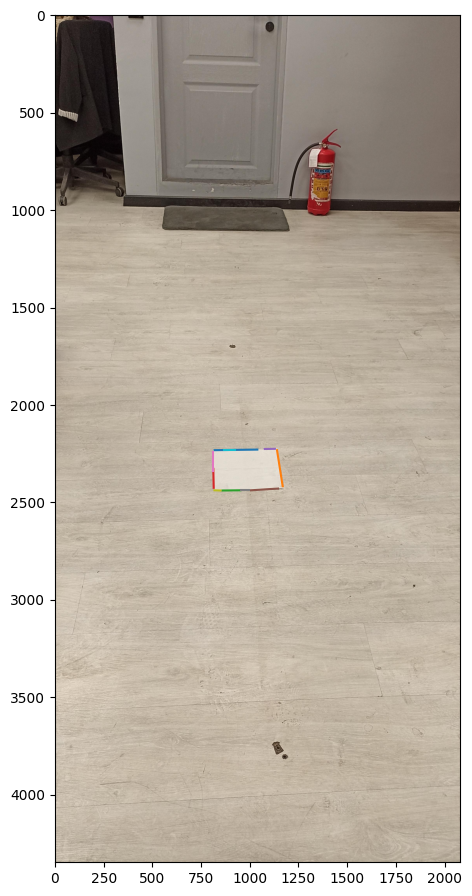

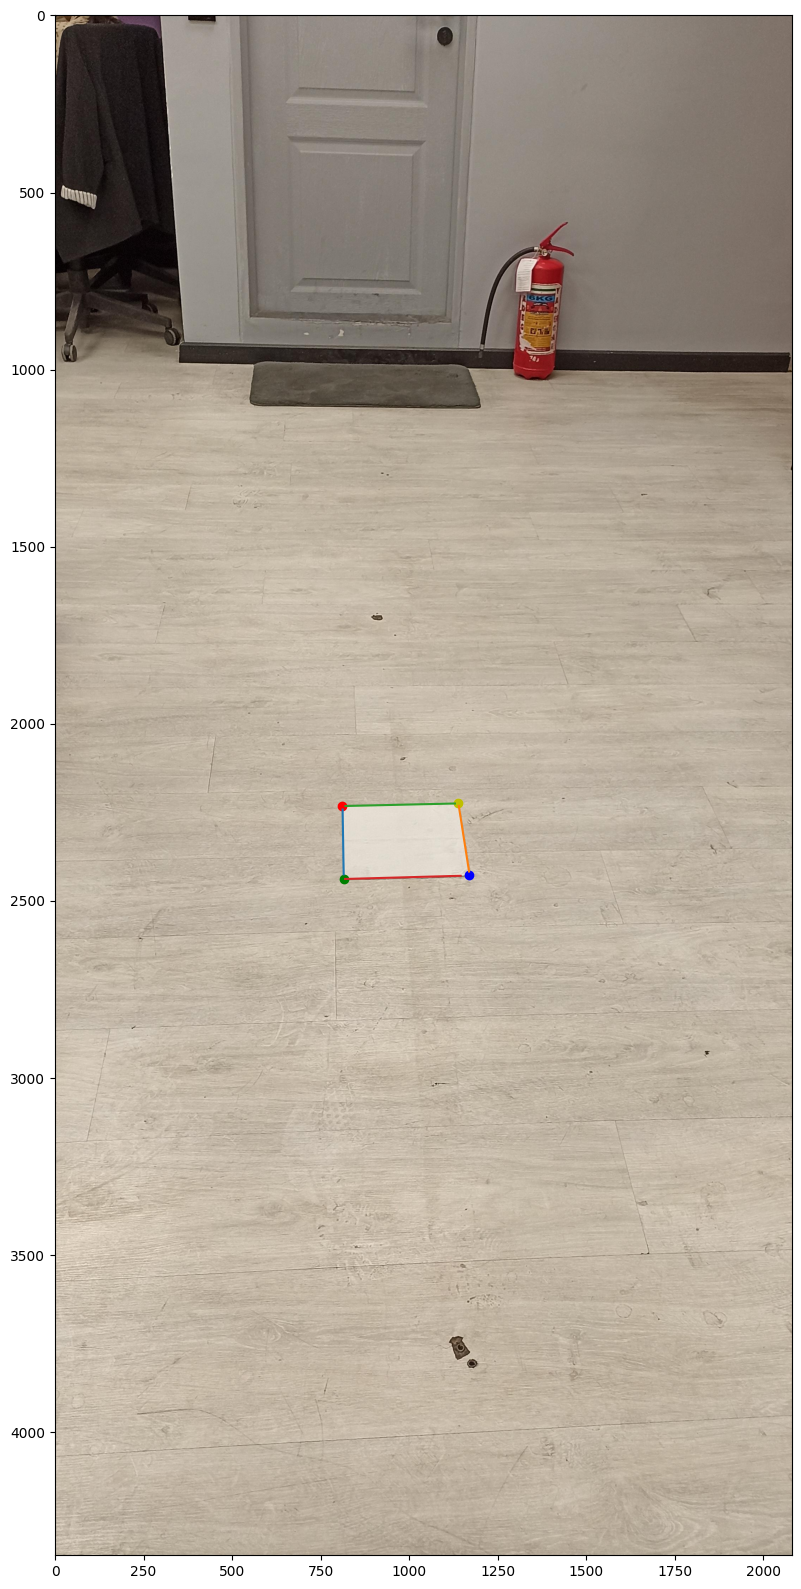

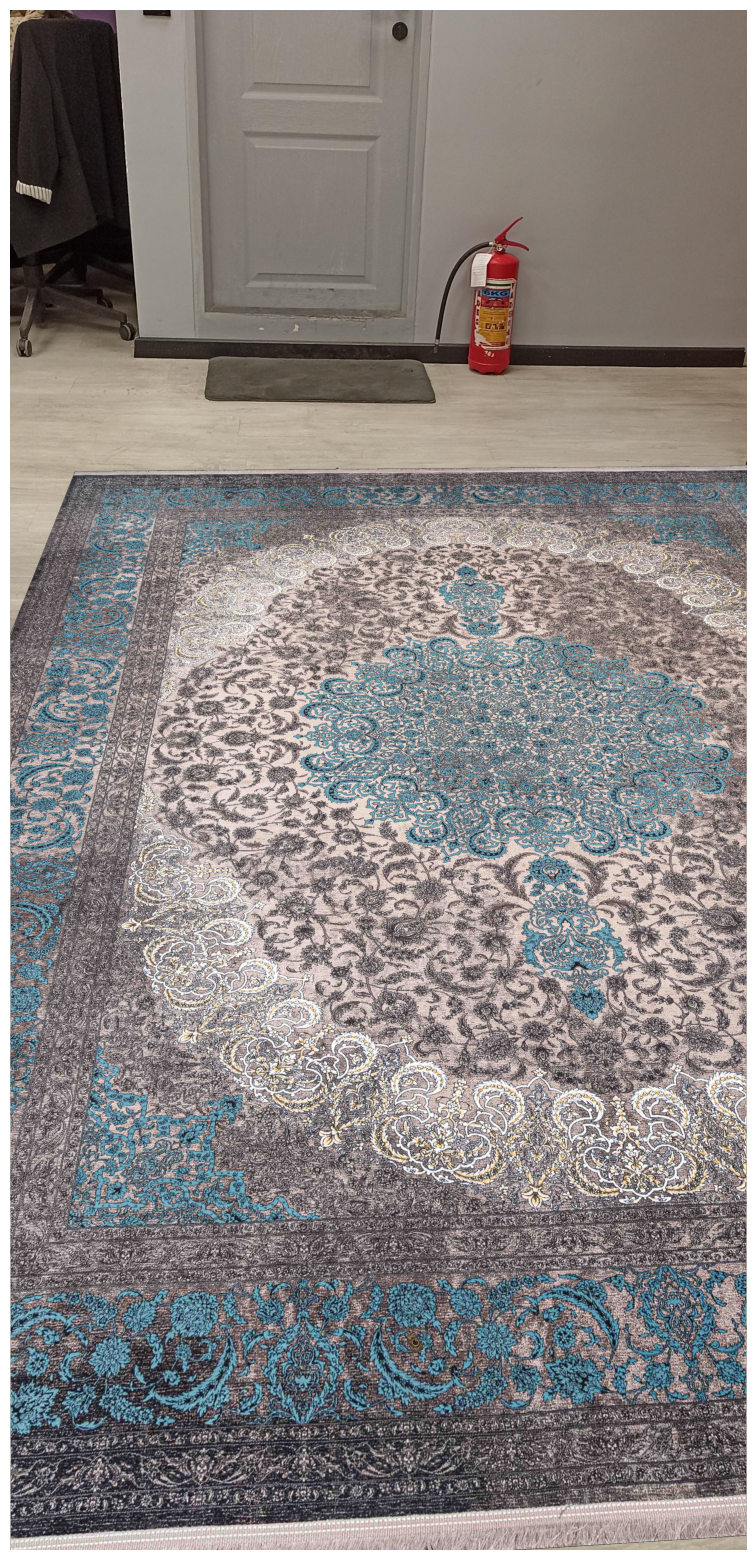

In [19]:
# preloading
sam2_model, sam_predictor, DEVICE = build_models()
# ------------------------------

IMAGE_PATH = "/content/8.jpg"
image_copy, new_img = load_image(IMAGE_PATH)
plt_image = plt.imread(IMAGE_PATH)

tissue_pixels, tissue_mask = segment_tissue(new_img, image_copy, sam_predictor, DEVICE)
floor_pixels, floor_mask = segment_floor(new_img, image_copy, sam_predictor, DEVICE)
mixed_mask = mix_tissue_and_floor_mask(tissue_mask, floor_mask)


coords = np.column_stack(np.where(tissue_mask > 0))
coords = np.vstack((coords[:, 1], coords[:, 0])).T.tolist()
mean = np.mean(coords, axis=0)

tissue_lines = detect_tissue_edges(tissue_pixels)
main_lines = find_main_lines(tissue_lines, mean)


plt.figure(figsize=(10,11))
plt.imshow(plt_image)


for line in tissue_lines:
    x1, y1, x2, y2 = line[0]
    plt.plot([x1, x2], [y1, y2])
plt.show()

plt.figure(figsize=(20,20))
plt.imshow(plt_image)
for line in main_lines:
    x1, y1, x2, y2 = line
    plt.plot([x1, x2], [y1, y2])

corners = find_corners_from_lines(main_lines, mean)
left_top, right_top, left_bottom, right_bottom = assign_corners(corners, mean)

plt.scatter(left_top[0], left_top[1], c='r')
plt.scatter(left_bottom[0], left_bottom[1], c='g')
plt.scatter(right_top[0], right_top[1], c='y')
plt.scatter(right_bottom[0], right_bottom[1], c='b')


plt.show()

corners = find_corners_from_lines(main_lines, mean)
left_top, right_top, left_bottom, right_bottom = assign_corners(corners, mean)


image = plt_image.copy()
original_img = image.copy()

points = draw_perspective_grid_advanced(image, left_bottom, left_top, right_bottom, right_top)

# Load the original image and the carpet image
carpet_img = cv2.imread('/content/rescaled.jpg')

pts_src = np.array([points[15][11], points[15][1], points[1][11], points[1][1]], dtype=np.float32)

carpet_height, carpet_width = carpet_img.shape[:2]

pts_dst = np.array([
    [0, 0],
    [carpet_width, 0],
    [0, carpet_height],
    [carpet_width, carpet_height]
], dtype=np.float32)

# Calculate Perspective Transform Matrix
M = cv2.getPerspectiveTransform(pts_dst, pts_src)


# Warp perspective
transformed_carpet = cv2.warpPerspective(carpet_img, M, (original_img.shape[1], original_img.shape[0]))

mask = np.all(transformed_carpet == [0, 0, 0], axis=-1)
alpha = np.ones_like(transformed_carpet[..., 0], dtype=np.float32)
alpha[mask] = 0
alpha2 = np.bitwise_and(mixed_mask[:,:,0].astype(int), alpha.astype(int))

# Add the alpha channel to the foreground image
new_un_warped_rgba_ = cv2.cvtColor(transformed_carpet, cv2.COLOR_BGR2RGB)
un_warped_normalized_ = new_un_warped_rgba_ / 255.0
un_warped_rgba_ = np.dstack((un_warped_normalized_, alpha2))


plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(plt_image)
plt.imshow(un_warped_rgba_)
plt.show()

